# Assignment 1

In [3]:
# Usual Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [4]:
food_inspection_data = pd.read_csv("../data/Food_Inspections.csv")
food_inspection_data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2572793,NORTHWEST ECC,NORTHWEST EARLY CHILDHOOD CENTER,4074227.0,School,Risk 1 (High),5252 N LONG,CHICAGO,IL,60630.0,03/20/2023,Canvass Re-Inspection,Pass,NaN,41.976477,-87.763673,"(41.976476658215724, -87.76367328987813)"
1,2572785,THE CHICKEN SHACK,THE CHICKEN SHACK,2528632.0,Restaurant,Risk 2 (Medium),7920 S WESTERN AVE,CHICAGO,IL,60620.0,03/17/2023,Canvass,Out of Business,NaN,41.749476,-87.682979,"(41.74947552001605, -87.68297883687882)"
2,2572772,STELIO'S BOTTLES & BITES,STELIO'S,2487437.0,Restaurant,Risk 3 (Low),19 S MORGAN ST,CHICAGO,IL,60607.0,03/17/2023,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.881102,-87.651865,"(41.881102463653505, -87.65186501694456)"
3,2572768,BLACKWOOD BBQ,BLACKWOOD BBQ,2326452.0,Restaurant,Risk 1 (High),28 S CLINTON ST,CHICAGO,IL,60661.0,03/17/2023,Non-Inspection,No Entry,NaN,41.880974,-87.641311,"(41.88097439290438, -87.64131135434275)"
4,2572764,CHIM THAI CUISINE,CHIM THAI CUISINE,2813666.0,Restaurant,Risk 1 (High),3254 W MONTROSE AVE,CHICAGO,IL,60618.0,03/17/2023,Canvass Re-Inspection,Pass,NaN,41.961271,-87.710463,"(41.96127134510051, -87.71046266805209)"


In [5]:
failed_inspection_data = food_inspection_data[(food_inspection_data["Results"]=="Fail") & (food_inspection_data["Violations"].notna())]

In [6]:
def extract_descriptions(violation):
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(?<=\d\.).*(?= - Comments)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.append(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    return regex_values

In [13]:
description_extract_df = failed_inspection_data["Violations"].apply(extract_descriptions)
description_extract_df = pd.DataFrame(description_extract_df.explode(),columns=["Violations"])

In [24]:
top10 = pd.DataFrame(description_extract_df.value_counts(),columns=["Count"])
top10.reset_index(inplace=True)
top10 = top10.rename(columns = {'index':'Violations'})
top10[:10]

,Violations,Count
0,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",19371
1,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",18257
2,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,16445
3,NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS...,16432
4,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",15834
5,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...,15529
6,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,15019
7,"PREMISES MAINTAINED FREE OF LITTER, UNNECESSAR...",10667
8,"INSECTS, RODENTS, & ANIMALS NOT PRESENT",8633
9,ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...,8288


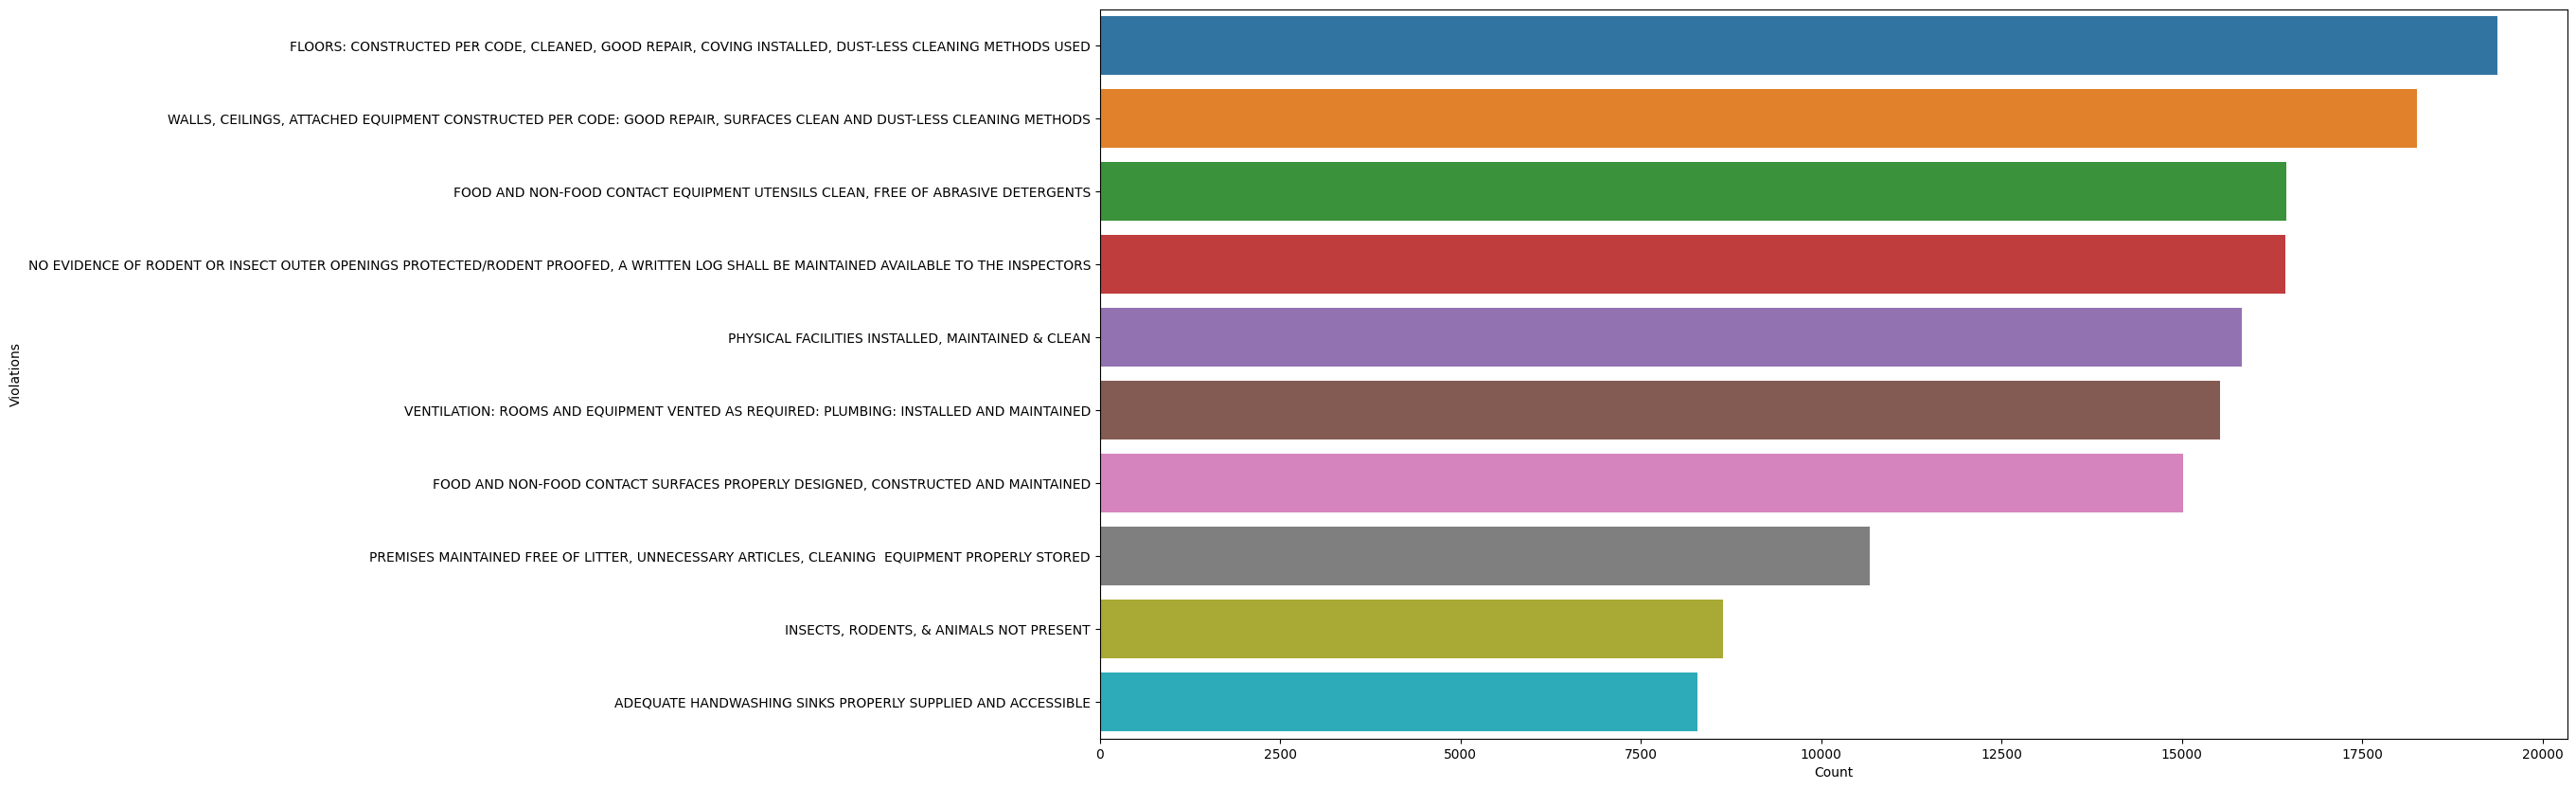

In [25]:
fig,axs = plt.subplots(1,1,figsize=(20,10))
top_violations = sns.barplot(data=top10[:10],x="Count",y="Violations",ax=axs)

In [26]:
failed_inspection_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45395 entries, 26 to 251037
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    45395 non-null  int64  
 1   DBA Name         45395 non-null  object 
 2   AKA Name         44930 non-null  object 
 3   License #        45393 non-null  float64
 4   Facility Type    45362 non-null  object 
 5   Risk             45394 non-null  object 
 6   Address          45395 non-null  object 
 7   City             45373 non-null  object 
 8   State            45385 non-null  object 
 9   Zip              45390 non-null  float64
 10  Inspection Date  45395 non-null  object 
 11  Inspection Type  45395 non-null  object 
 12  Results          45395 non-null  object 
 13  Violations       45395 non-null  object 
 14  Latitude         45236 non-null  float64
 15  Longitude        45236 non-null  float64
 16  Location         45236 non-null  object 
dtypes: float64

In [27]:
failed_inspection_data[failed_inspection_data["License #"].isna()]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
218203,670328,GOD'S BATTLE AXE PRAYER ACADEMY,GOD'S BATTLE AXE PRAYER ACADEMY,NaN,CHURCH/DAY CARE,Risk 1 (High),6969 N WESTERN AVE,CHICAGO,IL,60645.0,02/09/2012,Canvass,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",42.008303,-87.690005,"(42.008303130687445, -87.69000508529592)"
219335,679787,GOD'S BATTLE AXE PRAYER ACADEMY,GOD'S BATTLE AXE PRAYER ACADEMY,NaN,CHURCH/DAY CARE,Risk 1 (High),6969 N WESTERN AVE,CHICAGO,IL,60645.0,03/14/2012,Canvass Re-Inspection,Fail,"9. WATER SOURCE: SAFE, HOT & COLD UNDER CITY P...",42.008303,-87.690005,"(42.008303130687445, -87.69000508529592)"


As we can see, that the license # for the na columns will be the same as they are the same restaurant, so we can set a custom temporary license number for the time being.

In [28]:
failed_inspection_data[failed_inspection_data["License #"] == 99999999]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location


In [29]:
failed_inspection_data.loc[failed_inspection_data["License #"].isna(),"License #"] = 99999999

In [54]:
def extract_set_descriptions(violation):
    split_violations = violation.split(sep="|")
    regex_values = set()
    pattern = r"(?<=\d\.).*(?= - Comments)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.add(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.add(string)
    return list(regex_values)

In [55]:
failed_inspection_data["Custom_identifier"] = failed_inspection_data["License #"].astype(str) + "|" + failed_inspection_data["DBA Name"].str.strip() + "|" + failed_inspection_data["Address"].str.strip()
failed_inspection_data["Violations_List"] = failed_inspection_data["Violations"].apply(extract_set_descriptions)

C:\Users\yomaa\AppData\Local\Temp\ipykernel_21404\3410803879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_inspection_data["Custom_identifier"] = failed_inspection_data["License #"].astype(str) + "|" + failed_inspection_data["DBA Name"].str.strip() + "|" + failed_inspection_data["Address"].str.strip()
C:\Users\yomaa\AppData\Local\Temp\ipykernel_21404\3410803879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_inspection_data["Violations_List"] = failed_inspection_data["Violations"].ap

Thus we will use the License # and the address 

In [56]:
repeat_offenders = failed_inspection_data[["Custom_identifier","Violations_List"]]
repeat_offenders

,Custom_identifier,Violations_List
26,2822747.0|N&K ENTERTAINMENT LLC|1446 N WELLS ST,"[INSECTS, RODENTS, & ANIMALS NOT PRESENT, TOIL..."
92,2469807.0|SEAFOOD CITY SUPERMARKET/GRILL CITY/...,"[NON-FOOD/FOOD CONTACT SURFACES CLEAN, INSECTS..."
96,2762790.0|SUSHI KOI|2156 N CLYBOURN AVE,"[NON-FOOD/FOOD CONTACT SURFACES CLEAN, PROPER ..."
120,2771132.0|HALE FAMILY MCDONALD'S|1951 E 95th ST,"[NON-FOOD/FOOD CONTACT SURFACES CLEAN, INSECTS..."
124,1275547.0|FALCON FUEL|834 E 79TH ST,"[PLUMBING INSTALLED; PROPER BACKFLOW DEVICES, ..."
...,...,...
251014,2013575.0|TASTE THAT LLC|11322 S HALSTED ST BLDG,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R..."
251016,1892426.0|KJ'S CORNER|3234 N PULASKI RD,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R..."
251017,1974787.0|LITTLE LEARNING ACADEMY|7039 S WENTW...,[NO EVIDENCE OF RODENT OR INSECT OUTER OPENING...
251028,1596210.0|Food 4 Less Midwest #552|7030 S ASHL...,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R..."


In [88]:
Violation_list_grouped =  pd.DataFrame(repeat_offenders.groupby("Custom_identifier").agg({"Violations_List":sum}))
count_grouped = pd.DataFrame(repeat_offenders.groupby(["Custom_identifier"]).count())
joined_grouped = Violation_list_grouped.merge(count_grouped,on="Custom_identifier")
joined_grouped.reset_index(inplace=True)
joined_grouped.columns = ["Custom_identifier","Violations","Count"]
joined_grouped

,Custom_identifier,Violations,Count
0,0.0|16TH STREET NEWSSTAND|3934 W 16TH ST,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R...",1
1,0.0|AGUDATH ISREAL OF ILLINOIS|2828 W PRATT BLVD,"[LINEN: CLEAN AND SOILED PROPERLY STORED, FLOO...",1
2,0.0|ANTIOCH MISSIONARY BAPTIST CHURCH|415 W EN...,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R...",2
3,0.0|ASADO COFFEE ROASTERS|22 E JACKSON BLVD,[NO EVIDENCE OF RODENT OR INSECT OUTER OPENING...,1
4,0.0|ASSUMPTION BVM CHURCH|2434 S CALIFORNIA AVE,[NO EVIDENCE OF RODENT OR INSECT OUTER OPENING...,3
...,...,...,...
21034,9890.0|L & M STARLIGHT RESTAURANT INC|8300 S K...,[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,5
21035,99.0|XANDO COFFEE & BAR / COSI SANDWICH BAR|20...,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R...",1
21036,990.0|FALCO'S PIZZA|2806 W 40TH PL,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R...",5
21037,99050.0|CYDI COMMUNITY YOUTH DEVELOPMENT INSTI...,"[WAREWASHING FACILITIES: INSTALLED, MAINTAINED...",4


In [90]:
def check_if_duplicates(violation_list):
    violation_set  = set(violation_list)
    if len(violation_set) != len(violation_list):
        return "Repeat Violations"
    else:
        return "No Repeat Violations"

In [92]:
joined_grouped["Repeat Violations"] = joined_grouped["Violations"].apply(check_if_duplicates)
repeat_offender_df = joined_grouped[joined_grouped["Count"]>1]
repeat_offender_df

,Custom_identifier,Violations,Count,Repeat Violations
2,0.0|ANTIOCH MISSIONARY BAPTIST CHURCH|415 W EN...,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R...",2,Repeat Violations
4,0.0|ASSUMPTION BVM CHURCH|2434 S CALIFORNIA AVE,[NO EVIDENCE OF RODENT OR INSECT OUTER OPENING...,3,Repeat Violations
6,0.0|BABAS STEAK AND LEMONADE|3407 1/2 W MADISO...,"[INSECTS, RODENTS, & ANIMALS NOT PRESENT, PERS...",2,Repeat Violations
22,0.0|COUNTRY CORN|600 E GRAND AVE,[VENTILATION: ROOMS AND EQUIPMENT VENTED AS RE...,2,Repeat Violations
29,0.0|EMELIA OCAMPO|4422 W ARMITAGE AVE,[REFRIGERATION AND METAL STEM THERMOMETERS PRO...,2,Repeat Violations
...,...,...,...,...
21032,9821.0|FURAMA RESTAURANT INC|4936 N BROADWAY,"[NON-FOOD/FOOD CONTACT SURFACES CLEAN, PLUMBIN...",8,Repeat Violations
21034,9890.0|L & M STARLIGHT RESTAURANT INC|8300 S K...,[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,5,Repeat Violations
21036,990.0|FALCO'S PIZZA|2806 W 40TH PL,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R...",5,Repeat Violations
21037,99050.0|CYDI COMMUNITY YOUTH DEVELOPMENT INSTI...,"[WAREWASHING FACILITIES: INSTALLED, MAINTAINED...",4,Repeat Violations


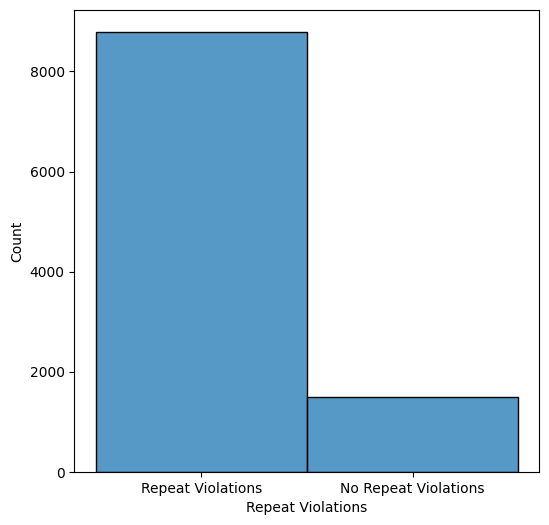

In [94]:
fig,axs = plt.subplots(1,1,figsize=(6,6))
hist = sns.histplot(data=repeat_offender_df,x="Repeat Violations",ax=axs)

In [95]:
closed_restaurant_data = food_inspection_data[(food_inspection_data["Results"]=="Out of Business")]

In [106]:
def No_of_Violations(violations):
    if pd.notnull(violations):
        split_violations = str(violations).split(sep="|")
        return len(split_violations)
    else:
        return 0

In [109]:
closed_restaurant_data["Violations Count"] = closed_restaurant_data["Violations"].apply(No_of_Violations)
closed_restaurant_data

C:\Users\yomaa\AppData\Local\Temp\ipykernel_21404\2180440040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_restaurant_data["Violations Count"] = closed_restaurant_data["Violations"].apply(No_of_Violations)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violations Count
1,2572785,THE CHICKEN SHACK,THE CHICKEN SHACK,2528632.0,Restaurant,Risk 2 (Medium),7920 S WESTERN AVE,CHICAGO,IL,60620.0,03/17/2023,Canvass,Out of Business,NaN,41.749476,-87.682979,"(41.74947552001605, -87.68297883687882)",0
10,2572676,PAISANS PIZZA MILWAUKEE,NaN,2803506.0,NaN,Risk 1 (High),1266 N MILWAUKEE AVE,CHICAGO,IL,60622.0,03/16/2023,Canvass,Out of Business,NaN,41.904690,-87.668781,"(41.90468982848127, -87.66878127418673)",0
12,2572653,ALLENDE RESTAURANT #2,ALLENDE RESTAURANT #2,1357345.0,Restaurant,Risk 1 (High),2221 N LINCOLN AVE,CHICAGO,IL,60614.0,03/16/2023,Canvass,Out of Business,NaN,41.922478,-87.644399,"(41.922477913374195, -87.64439904705058)",0
13,2572662,A-ILLINOIS INSTITUTE FOR CHILDREN,CHILD CARE CENTER,2215777.0,Daycare Above and Under 2 Years,Risk 1 (High),10009 S YATES AVE,CHICAGO,IL,60617.0,03/16/2023,Canvass,Out of Business,NaN,41.713211,-87.564436,"(41.71321088719611, -87.56443615534658)",0
17,2572706,ASIAN STATION,ASIAN STATION,2684167.0,Restaurant,Risk 1 (High),1343 W MORSE AVE,CHICAGO,IL,60626.0,03/15/2023,Canvass,Out of Business,NaN,42.007809,-87.665428,"(42.00780902250199, -87.66542847509838)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246282,277246,ARMANDO J DIAZ/TONY'S FOOD,ARMANDO J DIAZ/TONY'S FOOD,11273.0,NaN,Risk 2 (Medium),209 S LOTUS AVE,CHICAGO,IL,60644.0,07/12/2010,Canvass,Out of Business,NaN,41.878070,-87.761597,"(41.87807035543449, -87.76159665662685)",0
246294,251054,NEIGHBORHOOD FOOD MART INC,NEIGHBORHOOD FOOD MART INC,1479700.0,NaN,Risk 3 (Low),2748 W MADISON ST,CHICAGO,IL,60612.0,06/17/2010,Canvass,Out of Business,NaN,41.881191,-87.695806,"(41.88119123980771, -87.69580604798641)",0
246368,456947,YURIRIA RESTAURANT Y CENADURIA,YURIRIA RESTAURANT Y CENADURIA,1892401.0,NaN,Risk 1 (High),1632 W 47TH ST,CHICAGO,IL,60609.0,05/26/2010,Canvass,Out of Business,NaN,41.808699,-87.666234,"(41.808698515449116, -87.6662339034892)",0
248440,231327,MOUNTAIN VIEW CHEF INC,MOUNTAIN VIEW CHEF INC,1145427.0,Restaurant,Risk 1 (High),2168-2170 S ARCHER AVE,CHICAGO,IL,60616.0,04/13/2010,Out of Business,Out of Business,NaN,41.853167,-87.634461,"(41.85316719933144, -87.63446102872312)",0


In [134]:
grouped_closed_restaurants = closed_restaurant_data.groupby(["License #","DBA Name","Address"])["Violations Count"].sum().reset_index(inplace=False)
grouped_closed_restaurants

,License #,DBA Name,Address,Violations Count
0,0.0,ALTHEA BY MKC,700 N MICHIGAN AVE,0
1,0.0,BABAS STEAK AND LEMONADE,3407 1/2 W MADISON ST,0
2,0.0,BAR RISTA CAFE,1834 W MONTROSE AVE,0
3,0.0,BBQ SUPPLY,6948 N WESTERN AVE,0
4,0.0,BODY FACTORY NUTRITION,1500 W 51ST ST,2
...,...,...,...,...
20973,3639288.0,CHARTWELLS,2235 N HAMILTON AVE,0
20974,3676025.0,"CERES FOOD GROUP, INC.",8131 S MAY ST,0
20975,3759928.0,ARAMARK,13300 S LANGLEY,0
20976,3760620.0,NEW LIFE ACADEMY,2018 N RICHMOND AVE,0


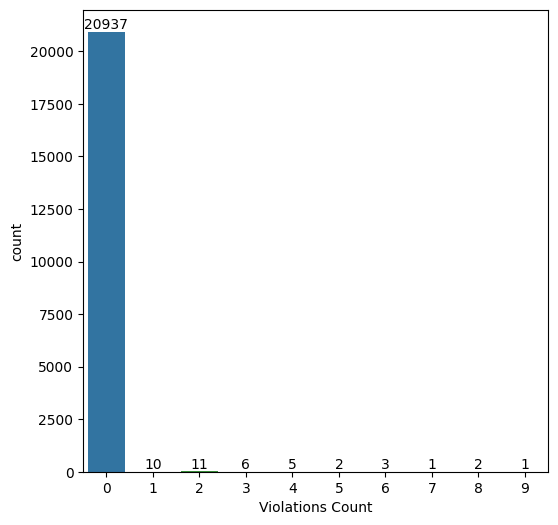

In [135]:
fig,axs = plt.subplots(1,1,figsize=(6,6))
hist = sns.countplot(data=grouped_closed_restaurants,x="Violations Count",ax=axs)
hist = hist.bar_label(hist.containers[0])

As we can see, the majority of "Out of Business" Restaurans have little to no violations.

In [153]:
def extract_descriptions_with_na(violation):
    if str(violation) != "nan":
        split_violations = violation.split(sep="|")
        regex_values = []
        pattern = r"(?<=\d\.).*(?= - Comments)"
        for i in split_violations:
            regex = re.search(pattern,i)
            if regex is None:
                string = i.strip()
                string = re.sub(r"(\d{1,3}. )","",string)
                regex_values.append(string)
            else:
                string  = i[regex.start(0):regex.end(0)].strip()
                regex_values.append(string)
        return regex_values
    else:
        return []

In [182]:
description_extract_df = pd.DataFrame()
description_extract_df["Violations"] = food_inspection_data["Violations"].apply(extract_descriptions_with_na)
description_extract_df["Time"] = food_inspection_data["Inspection Date"]
description_extract_df = description_extract_df.explode("Violations")
description_extract_df = description_extract_df[description_extract_df["Violations"].notna()]

In [183]:
description_extract_df["Year"] = pd.DatetimeIndex(description_extract_df['Time']).year
description_extract_df = description_extract_df.drop(["Time"],axis=1)
description_extract_df

,Violations,Year
2,ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...,2023
2,FOOD PROPERLY LABELED; ORIGINAL CONTAINER,2023
2,"UTENSILS, EQUIPMENT & LINENS: PROPERLY STORED,...",2023
5,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",2023
5,ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING,2023
...,...,...
251038,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,2010
251038,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",2010
251038,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",2010
251038,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...,2010


In [185]:
top5 = pd.DataFrame(description_extract_df["Violations"].value_counts(),columns=["Violations"])
top5.reset_index(inplace=True)
top5.columns = ["Violations","Count"]
top5[:5]

,Violations,Count
0,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",71794
1,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",64783
2,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,62915
3,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,54851
4,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...,54197
5,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",48684
6,"PREMISES MAINTAINED FREE OF LITTER, UNNECESSAR...",33319
7,LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIG...,25638
8,"FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PR...",21567
9,PROCEDURES FOR RESPONDING TO VOMITING AND DIAR...,17543


In [194]:
description_extract_agg = pd.DataFrame(description_extract_df.groupby(["Year","Violations"]).size())
description_extract_agg.reset_index(inplace=True)
selected_violations = description_extract_agg[description_extract_agg["Violations"].isin(top5[:5]["Violations"].values)]
selected_violations.columns = ["Year","Violations","Count"]
selected_violations

,Year,Violations,Count
9,2010,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",7804
11,2010,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,6787
12,2010,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,5731
39,2010,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...,5647
40,2010,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",7211
52,2011,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",8718
54,2011,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,7517
55,2011,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,6396
82,2011,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...,6413
83,2011,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",7681


In [195]:
selected_violations_pivot = selected_violations.pivot("Year","Violations","Count")
selected_violations_pivot

C:\Users\yomaa\AppData\Local\Temp\ipykernel_21404\2258762268.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  selected_violations_pivot = selected_violations.pivot("Year","Violations","Count")


Violations,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED","FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS","FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS"
Year,,,,,
2010,7804,6787,5731,5647,7211
2011,8718,7517,6396,6413,7681
2012,8101,7093,5661,5990,7158
2013,8742,7371,5967,6360,7049
2014,9467,8321,7010,7240,8264
2015,8412,7614,6883,6585,7739
2016,8917,8233,7193,6788,8355
2017,8163,7032,6861,6180,7629
2018,3470,2947,3149,2994,3697


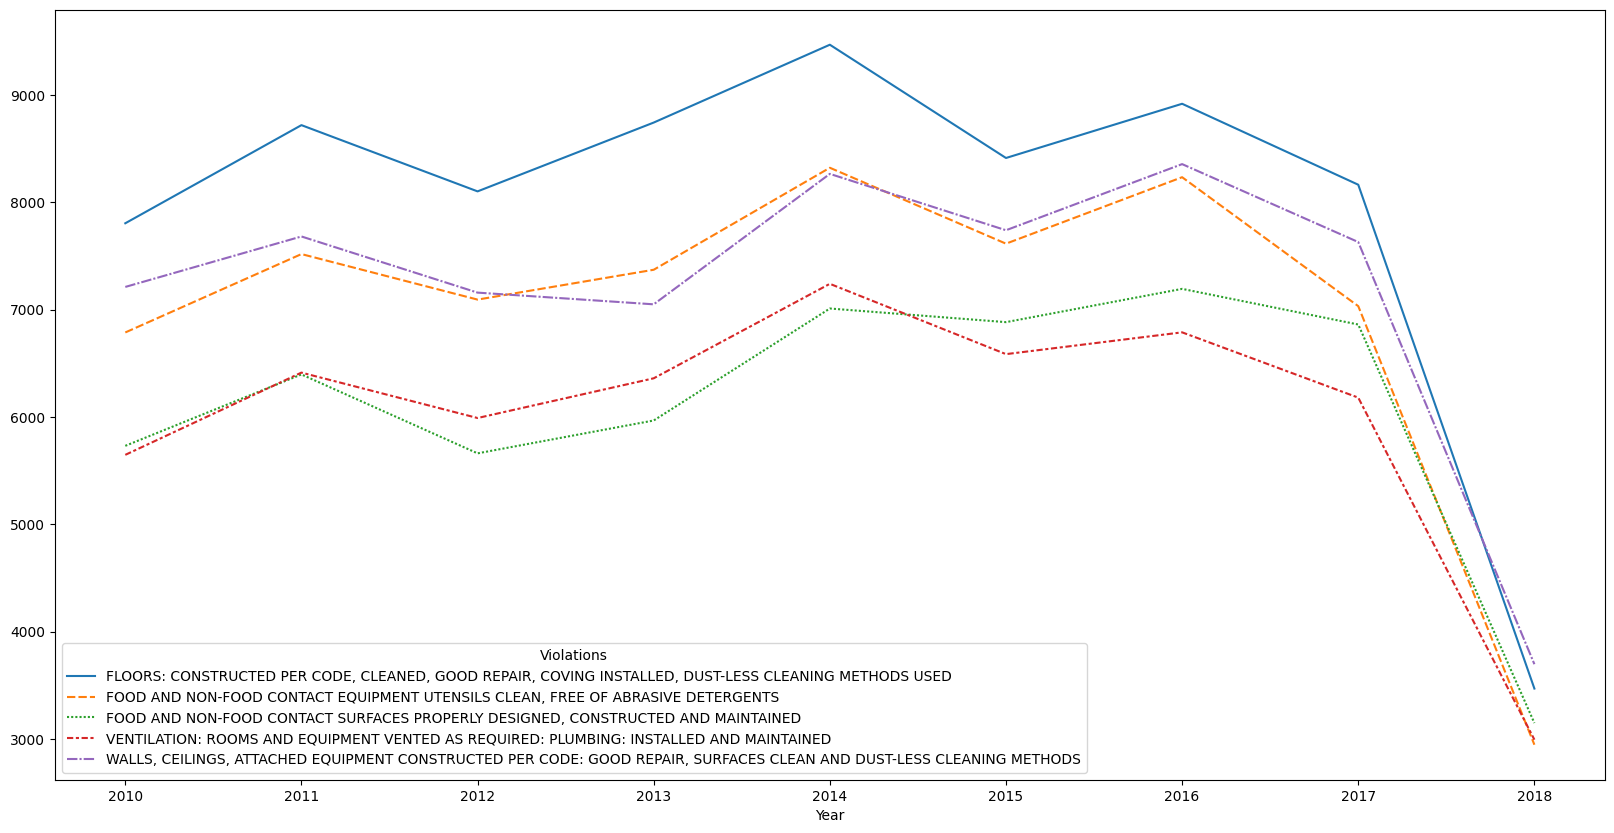

In [199]:
fig,axs = plt.subplots(1,1,figsize=(20,10))
lines = sns.lineplot(data=selected_violations_pivot,ax=axs)